# Matthew Makila HW3

In [10]:
# HW 3
import math
import pandas as pd
import copy
import time
import numpy as nump
import matplotlib.pyplot as plt

### File Import Function (to gather mileage data)

In [11]:
def file_import(f_name):    # for mileage data
    # specify features and the response var for file extraction and storage as a table
    feat_names = ['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
    f_feat_names = ['x0', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
    df = pd.read_csv(f_name, usecols=feat_names)
    resp_vect = df['mpg'].values.tolist()

    # scale the features
    scale_df = ((df - df.mean()) / df.std())

    # add vector for x0 of 1's; remove the response var
    x_0 = []
    for i in range(len(resp_vect)): x_0.append(1)
    scale_df = scale_df.drop('mpg', axis='columns')
    scale_df.insert(0, "x0", x_0, True)

    # create feature matrix to store all scaled features

    feat_matrix = []
    for feat in f_feat_names:
        feat_matrix.append(scale_df[feat].values.tolist())
    return feat_matrix, resp_vect


### Functions for Model Training

In [12]:
def gradient_descent(X, y, alpha, model, lamdba):
    # create vector to hold the theta values (past and present), initialize our theta vectors to 0
    start = time.time()
    runtime = 0
    iteration_list = []
    iterations = 0
    threshold = 0.00001
    m = len(y)  # number of observations
    thetas = []
    old_thetas = []
    diff_vect = []
    costs = []
    if model == 'linear':
        for i in range(len(X)):
            thetas.append(0)
            old_thetas.append(0)
            diff_vect.append(0)
    else:
        thetas = nump.zeros(len(X[0]))
        old_thetas = nump.zeros(len(X[0]))
        diff_vect = nump.zeros(len(X[0]))
    not_converged = True
    true_count = 0
    while not_converged:
        # loop over GDA equation algorithm
        for j in range(len(thetas)):    # loop to update each feature
            g_sum = 0
            for i in range(m):  # loop to compute each summation over all observations
                h_theta_x = 0
                if model == 'linear':
                    for n in range(len(thetas)):
                        h_theta_x += (old_thetas[n] * X[n][i])
                elif model == 'cancer':
                    p = -1 * (nump.dot(old_thetas, nump.array(X[i])))
                    h_theta_x = (1 / (1 + math.exp(p)))
                else:
                    p = -1 * (nump.dot(old_thetas, X[i]))
                    h_theta_x = (1 / (1 + math.exp(p)))
                if model == 'linear':
                    g_sum += (X[j][i] * (h_theta_x - y[i]))
                else:
                    g_sum += (X[i][j] * (h_theta_x - y[i]))
            # add back to new theta here
            if lamdba == 0:
                thetas[j] = old_thetas[j] - (alpha / m) * g_sum
            else:   # we are doing regularization
                if j == 0:  # treat j = 0 without reg
                    thetas[j] = old_thetas[j] - (alpha / m) * g_sum
                else:
                    thetas[j] = (old_thetas[j] * (1 - (alpha * lamdba) / m)) - (alpha / m) * g_sum

        # check differences of new thetas will old thetas & check threshold
        for i in range(len(thetas)):
            diff_vect[i] = abs(thetas[i] - old_thetas[i])
            if diff_vect[i] < threshold:
                true_count += 1

        # if all differences are less than threshold, we converged
        if true_count == len(diff_vect):
            not_converged = False
            end = time.time()
            runtime = end-start
        else:
            # update old thetas to continue GDA next iteration
            true_count = 0
            for i in range(len(thetas)):
                old_thetas[i] = thetas[i]
    return thetas, runtime, costs, iteration_list


def normal_equations(feat, resp, lamb):
    if lamb == 0:
        X1 = nump.array(feat).T
        y1 = nump.array(resp)
        temp = nump.dot(X1.T, X1)
        temp = nump.linalg.inv(temp)
        temp = nump.dot(temp, X1.T)
        temp = nump.dot(temp, y1)
        Theta = temp
    else:   # regularize
        X1 = nump.array(feat).T
        y1 = nump.array(resp)
        temp = nump.dot(X1.T, X1)
        # add new part here:    + (lamb * I)
        n = len(feat)
        row = nump.zeros(n)
        mat_I = nump.identity(n)
        m_df = pd.DataFrame(mat_I)
        m_df.loc[0] = row
        mat_I = m_df.to_numpy()
        mat_I = nump.dot(lamb, mat_I)
        temp = temp + mat_I
        temp = nump.linalg.inv(temp)
        temp = nump.dot(temp, X1.T)
        temp = nump.dot(temp, y1)
        Theta = temp
    return Theta

### Functions to Compute Training R-Squared Values and LOOCV R-Squared Values

In [13]:
def mpg_estimate(X, y, Theta):
    # create a vector of estimations (y hat)
    y_hat = []
    theta = nump.array(Theta)
    for i in range(len(y)):
        sample = []
        for j in range(len(X)):
            sample.append(X[j][i])
        # calculate a y hat with numpy: multiply theta transpose by that sample's features
        new_X = nump.array(sample)
        y_hat.append(nump.dot(theta, new_X))
    # calculate the error between observed and predicted
    calc_errors(y, y_hat, X)


def calc_errors(y, y_hat, X):
    error = nump.array(y) - nump.array(y_hat).T
    # calculate R^2 and adjusted R^2
    SSR = pow(error, 2)
    SST = pow((nump.array(y) - nump.array(nump.mean(y)).T), 2)
    R_Sq = 1 - (sum(SSR) / sum(SST))
    A_R_Sq = 1 - (1 - R_Sq) * ((len(y) - 1) / (len(y) - len(X)))
    print("R-Squared: ", R_Sq)
    print("Adjusted R-Squared: ", A_R_Sq)


def LOOCV(X, y, alpha, lamb, alg):
    m = len(y)
    n = len(X)
    y_hat = []
    for i in range(m):
        # remember original intact matrices for X and y while we remove 1 at a time
        n_X = copy.deepcopy(X)
        n_y = copy.deepcopy(y)
        # begin removals
        feat_to_predict = []
        n_y.pop(i)
        for j in range(n):  # save & remove all features of a specific example to predict later
            feat_to_predict.append(n_X[j][i])
            n_X[j].pop(i)
        if alg == 'gda':
            theta, run, cost, it = gradient_descent(n_X, n_y, alpha, 'linear', lamb)   # with 1 left out
            y_hat.append(nump.dot(theta, feat_to_predict))
        elif alg == 'norm':
            theta = normal_equations(n_X, n_y, lamb)
            y_hat.append(nump.dot(theta, feat_to_predict))
    calc_errors(y, y_hat, X)

### Function to Draw the Ridge Trace Plot

In [20]:
def ridge_trace_plot(X, y, alpha, alg):
    my_thetas = []
    lambs = nump.linspace(0, 10, num=101)   # our set of 101 different lambdas
    for i in range(len(lambs)):     # yes, we run it 101 times for each lambda
        if alg == 'gda':
            theta, run, cost, it = gradient_descent(X, y, alpha, 'linear', lambs[i])
            my_thetas.append(theta)
        elif alg == 'norm':
            theta = normal_equations(X, y, lambs[i])
            my_thetas.append(theta)
    my_thetas = pd.DataFrame(my_thetas)
    my_thetas = my_thetas.transpose().values.tolist()
    # no need to plot theta 0
    for i in range(len(my_thetas) - 1):
        plt.plot(lambs, my_thetas[i + 1], label="theta {}".format(i + 1))

    plt.legend()
    plt.title("Ridge Trace")
    plt.ylabel("Standardized Coefficient")
    plt.xlabel("Ridge Parameter")
    plt.show()

### Part 1 (A)

In [17]:
X_, y_ = file_import('mileage.csv')
a = 0.2
"""1"""

# 1A: calculate regular MLR and then LOOCV MLR
print("\n-----------------1A---------------\n")
Thetas, runtime, costs, iterations = gradient_descent(X_, y_, a, 'linear', 0)
print("Training:")
mpg_estimate(X_, y_, Thetas)
print("LOOCV:")
LOOCV(X_, y_, a, 0, 'gda')

df = pd.DataFrame()
df.insert(0, "Model Parameters (No Regularization)", Thetas, True)
print(df)


-----------------1A---------------

Training:
R-Squared:  0.8690157579509393
Adjusted R-Squared:  0.8066423093561486
LOOCV:
R-Squared:  0.6538538719944074
Adjusted R-Squared:  0.4890223824679346
    Model Parameters (No Regularization)
0                              20.090625
1                              -0.198497
2                               1.650594
3                              -1.472098
4                               0.421023
5                              -3.633588
6                               1.466665
7                               0.160140
8                               1.257569
9                               0.483800
10                             -0.323234


##### The results above show the model fit for the training and Leave One Out Cross Validation (LOOCV). We notice here the training fit is quite high, while the LOOCV fit is relatively low in comparison. This tells us our model is overfitting and not performing well on testing data.

### Part 1 (B)

In [18]:
# 1B: regular MLR and LOOCV MLRs with Regularization
print("\n-----------------1B---------------\n")
reg_param = 6.5
Thetas2, runtime2, costs2, iterations2 = gradient_descent(X_, y_, a, 'linear', reg_param)
print("Training:")
mpg_estimate(X_, y_, Thetas2)
print("LOOCV:")
LOOCV(X_, y_, a, reg_param, 'gda')
df2 = pd.DataFrame()
df2.insert(0, "Model Parameters (Regularization)", Thetas2, True)
print(df2)


-----------------1B---------------

Training:
R-Squared:  0.8561902544285618
Adjusted R-Squared:  0.7877094232040673
LOOCV:
R-Squared:  0.7878648194045034
Adjusted R-Squared:  0.6868480667399812
    Model Parameters (Regularization)
0                           20.090625
1                           -0.591617
2                           -0.525895
3                           -0.840148
4                            0.546280
5                           -1.472724
6                            0.362866
7                            0.316174
8                            0.937010
9                            0.424887
10                          -1.028183


#### The results depicted above make use of the regularization parameter (lambda). Here, with a chosen lambda of 6.5, we see much improvement in the LOOCV fit of the model though there's a decrease in the training fit. This leads to better testing performance.

### Part 1 (C)

### We can see there is a significant improvement in the R-squared values from the initial models to the ones trained using regularization. The models that used regularization have a much better LOOCV fit, with the training fit decreasing, as expected. We can also notice the shrinkage in the model parameters, as expected by the regularization's change to the cost function, since we were multiplying theta by a number smaller than 1 while training.

### Part 1 (D)

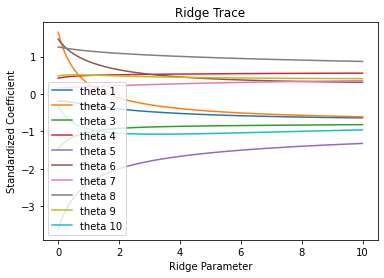

In [21]:
# 1D: Ridge Trace Plot
ridge_trace_plot(X_, y_, a, 'gda')

##### We can see in the above plot that the model parameters show signicifant change up until lambda equals 7, and then the model parameters are relatively consistent.

### Part 1 (E)

### If I were to make a choice for the best regularization parameter, I would pick a number near lambda = 8. I would make this choice because it would give us a point where the lambda values have been consistent and will not change much through continually increasing the regularization parameter. 

### Part 2 (A)

In [23]:
# 2A
print("\n-----------------2A---------------\n")
norm_theta = normal_equations(X_, y_, 0)
print("Training:")
mpg_estimate(X_, y_, norm_theta)
print("LOOCV:")
LOOCV(X_, y_, a, 0, 'norm')
df3 = pd.DataFrame()
df3.insert(0, "Norm. Equations Model Parameters (No Regularization)", norm_theta, True)
print(df3)


-----------------2A---------------

Training:
R-Squared:  0.8690157644777647
Adjusted R-Squared:  0.806642318990986
LOOCV:
R-Squared:  0.653824581644487
Adjusted R-Squared:  0.4889791443323379
    Norm. Equations Model Parameters (No Regularization)
0                                           20.090625   
1                                           -0.199024   
2                                            1.652752   
3                                           -1.472876   
4                                            0.420851   
5                                           -3.635267   
6                                            1.467153   
7                                            0.160158   
8                                            1.257570   
9                                            0.483566   
10                                          -0.322102   


##### The results above show the model fit for the training and Leave One Out Cross Validation (LOOCV). We notice here the training fit is quite high, while the LOOCV fit is relatively low in comparison. This tells us our model is overfitting and not performing well on testing data.

### Part 2 (B)

In [25]:
# 2B
reg_param2 = 6.5
print("\n-----------------2B---------------\n")
norm_theta2 = normal_equations(X_, y_, reg_param2)
print("Training:")
mpg_estimate(X_, y_, norm_theta2)
print("LOOCV:")
LOOCV(X_, y_, a, reg_param2, 'norm')
df4 = pd.DataFrame()
df4.insert(0, "Norm. Equations Model Parameters (Regularization)", norm_theta2, True)
print(df4)


-----------------2B---------------

Training:
R-Squared:  0.8561919996838382
Adjusted R-Squared:  0.787711999533285
LOOCV:
R-Squared:  0.7878593043821911
Adjusted R-Squared:  0.6868399255165678
    Norm. Equations Model Parameters (Regularization)
0                                           20.090625
1                                           -0.591588
2                                           -0.525683
3                                           -0.840225
4                                            0.546272
5                                           -1.472916
6                                            0.362964
7                                            0.316175
8                                            0.937024
9                                            0.424884
10                                          -1.028075


#### The results depicted above make use of the regularization parameter (lambda). Here, with a chosen lambda of 6.5, we see much improvement in the LOOCV fit of the model though there's a decrease in the training fit. This leads to better testing performance.

### Part 2 (C)

### Like with the GDA method, we can see there is a significant improvement in the R-squared values from the initial models to the ones trained using regularization. The models that used regularization have a much better LOOCV fit, with the training fit decreasing, as expected. We can also notice the shrinkage in the model parameters, as expected by the regularization's change to the cost function, since we were multiplying theta by a number smaller than 1 while training.

### Part 2 (D)

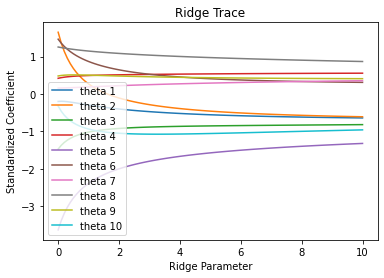

In [26]:
# 2D
ridge_trace_plot(X_, y_, a, 'norm')

##### We can see in the above plot that the model parameters show signicifant change up until lambda equals 7, and then the model parameters are relatively consistent.

### Part 2 (E)

### As with GDA, if I were to make a choice for the best regularization parameter, I would pick a number near lambda = 8. I would make this choice because it would give us a point where the lambda values have been consistent and will not change much through continually increasing the regularization parameter. 